### Initial data analysis of SAP data

In [1]:
import dask.dataframe as dd
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from plotnine import *
import matplotlib.pyplot as plt
import os
import collections
import math
%matplotlib inline

In [2]:
data_dir = '../data/raw/'
df_sales = pd.read_csv(data_dir+'sales.csv', delimiter='\t', parse_dates=['EVENT_DATE'])
df_cust = pd.read_csv(data_dir+'Customers.csv', delimiter='\t')
df_mail_train = pd.read_csv(data_dir+'Mailings1_2.csv', parse_dates=['REF_DATE'])
df_demog = pd.read_csv(data_dir+'Demog.csv', delimiter='\t')
df_mail_test = pd.read_csv(data_dir+'Mailings3.txt',delimiter='\t', parse_dates=['REF_DATE'])

In [3]:
print(df_sales.shape)
df_sales.head(3)

(3420829, 4)


,EVENTID,REFID,EVENT_DATE,AMOUNT
0,0,0,2006-12-21 12:00:00,17.907000
1,1,0,2006-12-25 12:00:00,17.400999
2,2,0,2007-01-26 12:00:00,13.277000


In [4]:
print(df_cust.shape)
df_cust.head(3)

(360000, 13)


,ID,SEX,MARITAL_STATUS,GEOID,EDUCATIONNUM,OCCUPATION,DATA1,DATA2,DATA3,NOM1,NOM2,NOM3,age
0,0,Male,Never-married,61,7,Machine-op-inspct,9.276,3.592,8.253,l,p,o,62
1,1,Male,Married-civ-spouse,70,3,Handlers-cleaners,5.836,4.574,5.507,u,r,x,78
2,2,Male,Never-married,53,7,Machine-op-inspct,8.998,4.184,8.593,n,q,o,69


In [5]:
print(df_mail_train.shape)
df_mail_train.head(3)

(60000, 4)


,REFID,KxIndex,REF_DATE,RESPONSE
0,0,1,2007-02-01 12:00:00,False
1,1,2,2007-02-01 12:00:00,False
2,2,3,2007-02-01 12:00:00,False


In [6]:
print(df_demog.shape)
df_demog.head(3)

(200, 21)


,GEOID,INHABITANTS_K,INCOME_K,A_VAR1,A_VAR2,A_VAR3,A_VAR4,A_VAR5,A_VAR6,A_VAR7,...,A_VAR9,A_VAR10,A_VAR11,A_VAR12,A_VAR13,A_VAR14,A_VAR15,A_VAR16,A_VAR17,A_VAR18
0,0,30.046,2631.468018,6.084,5.790,8.595,3.935,6.362,8.626,4.624,...,5.233,6.232,5.205,8.231,6.746,8.679,5.292,3.500,5.512,5.783
1,1,36.250,3012.745117,4.604,8.309,6.007,5.938,8.773,3.579,6.349,...,6.884,7.062,7.319,3.720,6.405,7.202,4.932,7.969,8.150,5.633
2,2,47.645,2192.410889,4.911,8.557,5.934,6.494,9.172,3.202,6.157,...,7.942,7.901,7.928,2.330,6.029,6.455,4.720,8.564,8.342,4.938


In [7]:
print(df_mail_test.shape)
df_mail_test.head(3)

(300000, 3)


,REFID,REF_DATE,RESPONSE
0,60000,2007-07-01 12:00:00,False
1,60001,2007-07-01 12:00:00,False
2,60002,2007-07-01 12:00:00,False


### Chcking for quality of data

- does any of the data have any missing values?
- do all GEOID in customers data exist in the demographic data?
- do all REFIDs in sales data exist as the ID in customers data?
- do all REFID in mail data exist as ID in the customers' data?

We notice from below that there are some values in customers data that is missing.  After digging further, there are 131 values missing from the NOM1 column, which is a categorical feature.  For this, we prepare two different approaches and see which one does better:
- Remove the 131 rows because it's a very small sample of the data
- Use a RF classifier to fill in the NOM1 values 
    - A RF was used here because of it's ability to fit to the training data very well. 


In [8]:
# does any of the data have any missing values?
print('any sales data values missing? {}'.format(df_sales.isnull().values.any()))
print('any customer data values missing? {}'.format(df_cust.isnull().values.any()))
print('any demographic data values missing? {}'.format(df_demog.isnull().values.any()))
print('any mail_train data values missing? {}'.format(df_mail_train.isnull().values.any()))
print('any mail_test data values missing? {}'.format(df_mail_test.isnull().values.any()))

any sales data values missing? False
any customer data values missing? True
any demographic data values missing? False
any mail_train data values missing? False
any mail_test data values missing? False


In [9]:
# checking on missing customer data
df_cust.isnull().any()

ID                False
SEX               False
MARITAL_STATUS    False
GEOID             False
EDUCATIONNUM      False
OCCUPATION        False
DATA1             False
DATA2             False
DATA3             False
NOM1               True
NOM2              False
NOM3              False
age               False
dtype: bool

In [10]:
# How many nans are in NOM1?
sum(df_cust.NOM1.isnull())

131

In [11]:
df_cust_null_dropped = df_cust[~df_cust.NOM1.isnull()]
df_cust_null_dropped.to_csv('../data/raw/customers_dropped_null.csv', index=False)

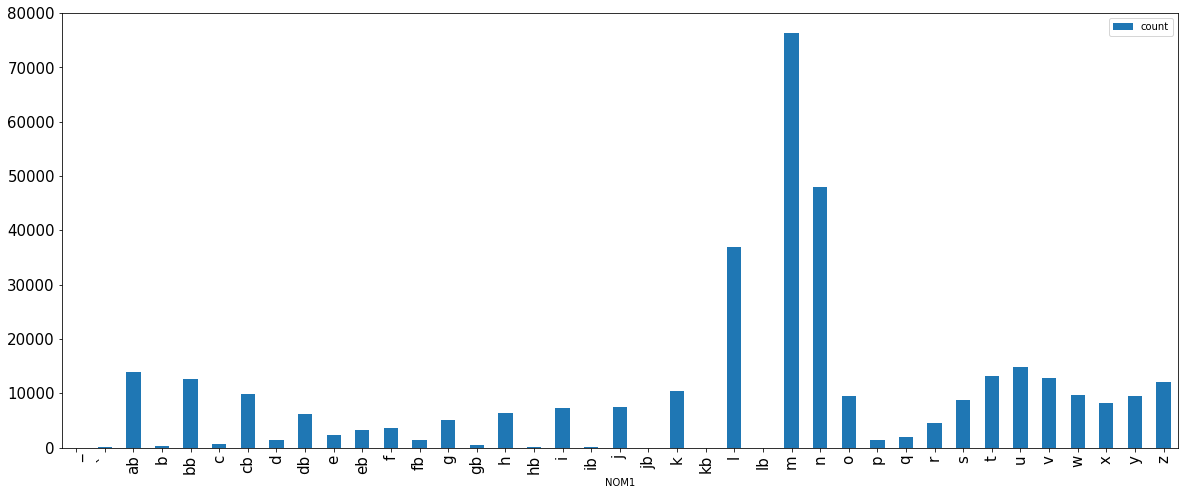

In [97]:
ax = df_cust.groupby('NOM1').size().to_frame('count').plot(kind='bar', figsize=(20,8), fontsize=15)


In [13]:
# do all GEOID in customers data exist in the demographic data?
print('are all customer GEOID data in DEMOG dataset? {}'.format(all(df_cust.GEOID.isin(df_demog.GEOID.values))))

are all customer GEOID data in DEMOG dataset? True


In [14]:
# do all REFIDs in sales data exist as the ID in customers data?
print('are all REFIDs in sales exist in customer data? {}'.format(all(df_sales.REFID.isin(df_cust.ID.values))))

are all REFIDs in sales exist in customer data? True


In [15]:
# do all REFID in mail data exist as ID in the customers' data?
print('are all mail REFID in customers data? {}'.format(all(pd.concat([df_mail_train.REFID, df_mail_test.REFID]).isin(df_cust.ID))))

are all mail REFID in customers data? True


### Using a RF classifier to fill in remaining NOM1 values

To create the training dataset, we do the following steps:
- keep the NOM1 column separately
- dummy the rest of the dataframe, then append the NOM1 colum to the end.
- Split the dataset into train and test, where train are the rows there NOM1 != null, and test is the rest.
- Fit a RF classifier to the training data, and use it to predict the NOM1 values for the testing.

In [16]:
nom1_values = df_cust.NOM1
df_cust_dummied = pd.concat([pd.get_dummies(df_cust.drop('NOM1',axis=1)), nom1_values],axis=1)
df_cust_dummied.shape

(360000, 84)

In [17]:
train_data = df_cust_dummied[~df_cust_dummied.NOM1.isnull()]
test_data = df_cust_dummied[df_cust_dummied.NOM1.isnull()]
train_data.shape, test_data.shape

((359869, 84), (131, 84))

In [18]:
train_x = train_data.drop('NOM1', axis=1)
train_y = train_data['NOM1']
test_x = test_data.drop('NOM1', axis=1)

In [22]:
clf = RandomForestClassifier()

In [23]:
clf.fit(train_x, train_y)

/usr/local/Cellar/python3/3.6.4_2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [24]:
predictions = clf.predict(test_x)

In [25]:
# Fill in the nan values
for i,index in enumerate(test_data.index):
    df_cust.loc[index, 'NOM1'] = predictions[i]

In [26]:
print('any NOM1 values null? {}'.format(any(df_cust.NOM1.isnull())))

any NOM1 values null? False


In [27]:
df_cust.to_csv('../data/raw/customers_fill_nan.csv',index=False)

## Sales Data Analysis

Since we already know that there are no missing values in this dataframe, we will visualize any trends in the sales patterns and amounts.

In [28]:
df_sales.head(2)

,EVENTID,REFID,EVENT_DATE,AMOUNT
0,0,0,2006-12-21 12:00:00,17.907000
1,1,0,2006-12-25 12:00:00,17.400999


In [29]:
sales_by_day = df_sales.groupby([df_sales.EVENT_DATE.dt.year, df_sales.EVENT_DATE.dt.month, df_sales.EVENT_DATE.dt.day], as_index=False).size()
sales_by_day = sales_by_day.to_frame('count')
sales_by_day.index = sales_by_day.index.set_names(['year','month','day'])
sales_by_day.reset_index(inplace=True)
sales_by_day.head(2)

,year,month,day,count
0,2006,11,9,3369
1,2006,11,10,3412


In [30]:
df_sales_grouped = df_sales.groupby('EVENT_DATE').size().to_frame('count')

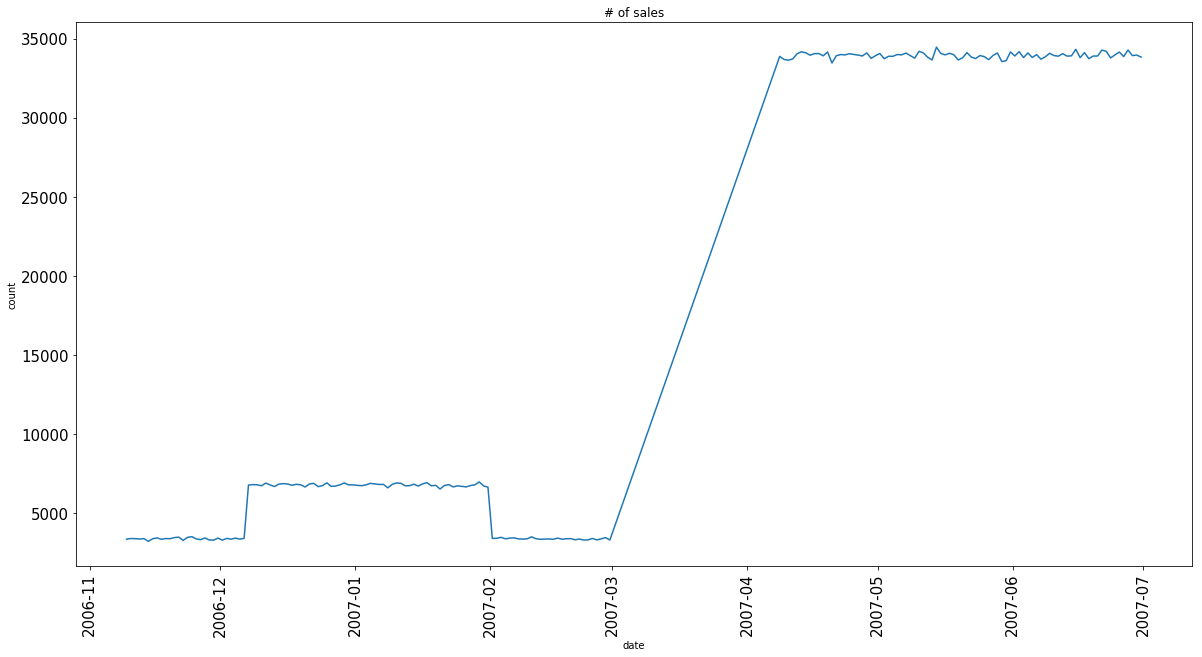

In [31]:
fig, ax = plt.subplots(figsize=(20,10))
plt.plot(df_sales_grouped.index, df_sales_grouped['count'])
plt.xticks(rotation='vertical', fontsize=15)
plt.yticks(fontsize=15)
plt.title('# of sales')
plt.ylabel('count')
plt.xlabel('date')
plt.show()

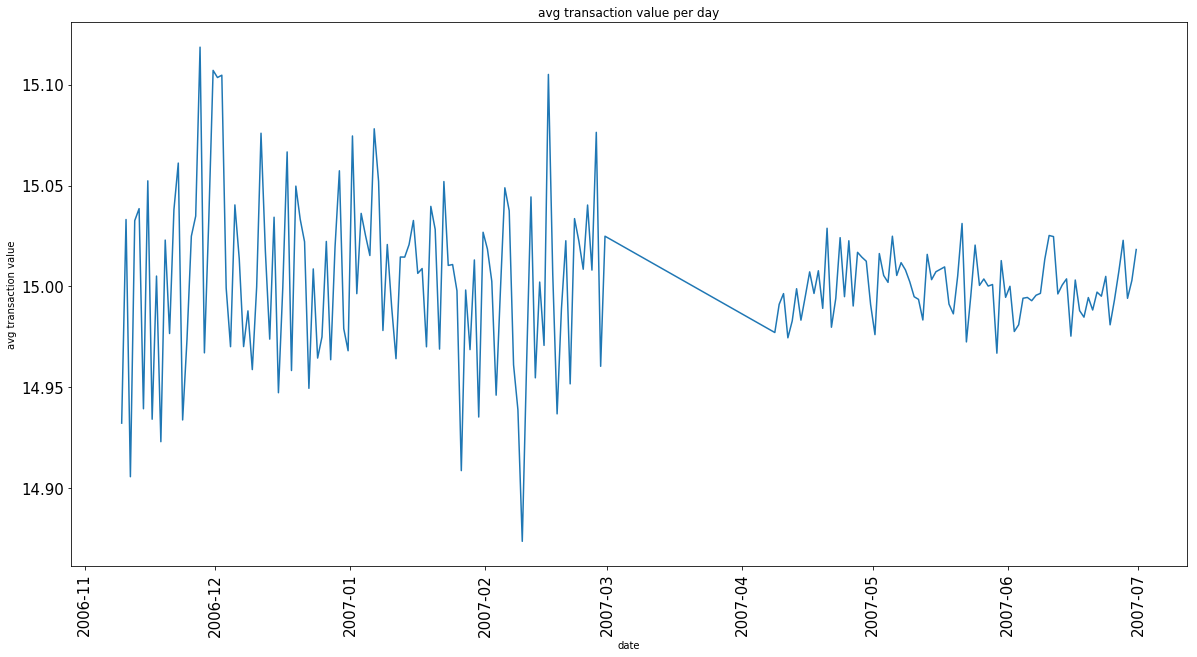

In [32]:
avg_transaction_value = df_sales[['EVENT_DATE', 'AMOUNT']].groupby("EVENT_DATE").mean()
fig, ax = plt.subplots(figsize=(20,10))
plt.plot(avg_transaction_value.index, avg_transaction_value['AMOUNT'])
plt.xticks(rotation='vertical', fontsize=15)
plt.yticks(fontsize=15)
plt.title('avg transaction value per day')
plt.ylabel('avg transaction value')
plt.xlabel('date')
plt.show()

Notice that there is no march data for 2007.  And we see two spikes in number of transactions: 
- small spike in January 2006 which ended in Feburary 2006
- Big spike in April 2007 which stayed

The average transaction amount has not changed, so these spikes were not caused by any price changes.  Most likely they were caused by targeted advertising/campaigns to attract customers.

## Mail Training Sample Analysis

Since there are no missing values in the email dataset, we are going to analyze the frequency and the responses of the emails.

In [33]:
df_mail_train.head(2)

,REFID,KxIndex,REF_DATE,RESPONSE
0,0,1,2007-02-01 12:00:00,False
1,1,2,2007-02-01 12:00:00,False


In [34]:
df_mail_train.REF_DATE.unique()

array(['2007-02-01T12:00:00.000000000', '2007-03-01T12:00:00.000000000'],
      dtype='datetime64[ns]')

In [35]:
df_mail_grouped = df_mail_train[['REF_DATE','RESPONSE']].groupby("REF_DATE")
sent_mail_by_day = df_mail_grouped.size().to_frame('count')
resp_rate_by_day = df_mail_grouped.mean()

In [36]:
sent_mail_by_day.head()

,count
REF_DATE,
2007-02-01 12:00:00,30000
2007-03-01 12:00:00,30000


In [37]:
resp_rate_by_day.head()

,RESPONSE
REF_DATE,
2007-02-01 12:00:00,0.0510
2007-03-01 12:00:00,0.0488


This dataset explains that the company did do some email marketing during Feburary and March of 2007.  That explains the spike we saw in the sales data.  Since there is not much content in this dataset, we will have to combine this with the demographic dataset and analyze further if certain customer segments are more likely to respond to emails.

## Demographic data analysis

We'd like to understand if the email campaigns worked on certain demographics.  So we will join the demographic dataset with the emails and customers dataset to analyze further. 

In [38]:
df_demog.head(2)

,GEOID,INHABITANTS_K,INCOME_K,A_VAR1,A_VAR2,A_VAR3,A_VAR4,A_VAR5,A_VAR6,A_VAR7,...,A_VAR9,A_VAR10,A_VAR11,A_VAR12,A_VAR13,A_VAR14,A_VAR15,A_VAR16,A_VAR17,A_VAR18
0,0,30.046,2631.468018,6.084,5.790,8.595,3.935,6.362,8.626,4.624,...,5.233,6.232,5.205,8.231,6.746,8.679,5.292,3.500,5.512,5.783
1,1,36.250,3012.745117,4.604,8.309,6.007,5.938,8.773,3.579,6.349,...,6.884,7.062,7.319,3.720,6.405,7.202,4.932,7.969,8.150,5.633


In [44]:
df_cust.head(2)

,ID,SEX,MARITAL_STATUS,GEOID,EDUCATIONNUM,OCCUPATION,DATA1,DATA2,DATA3,NOM1,NOM2,NOM3,age
0,0,Male,Never-married,61,7,Machine-op-inspct,9.276,3.592,8.253,l,p,o,62
1,1,Male,Married-civ-spouse,70,3,Handlers-cleaners,5.836,4.574,5.507,u,r,x,78


In [45]:
df_mail_train.head(2)

,REFID,KxIndex,REF_DATE,RESPONSE
0,0,1,2007-02-01 12:00:00,False
1,1,2,2007-02-01 12:00:00,False


In [54]:
dd = pd.merge(df_mail_train[['REFID','RESPONSE']], df_cust[['ID','GEOID']], left_on='REFID',right_on='ID')

In [89]:
df_merged = pd.merge(df_mail_train[['REFID','RESPONSE']], df_cust[['ID','GEOID']], left_on='REFID',right_on='ID')
df_merged = pd.merge(df_merged[['RESPONSE','GEOID']], df_demog)
print('reponse rate is: {}'.format(df_merged.RESPONSE.mean()))

reponse rate is: 0.0499


In [79]:
# Check how much emails have been sent to different demographics
df_merged.GEOID.value_counts().sort_values().head(10)

6      1
112    1
116    1
124    1
119    1
118    1
3      2
114    2
113    2
2      2
Name: GEOID, dtype: int64

In [85]:
# We see that there age locations where we sent very few number of emails.  Therefore, we limit the data visualized below to 
# geoIDs where there were more than 10 emails sent.
geoid_counts = df_merged.GEOID.value_counts()
valid_geoids = geoid_counts[geoid_counts>10].index


Text(0.5, 1.0, 'Reponse Rate of Different GEOIDS with more than 10 emails sent')

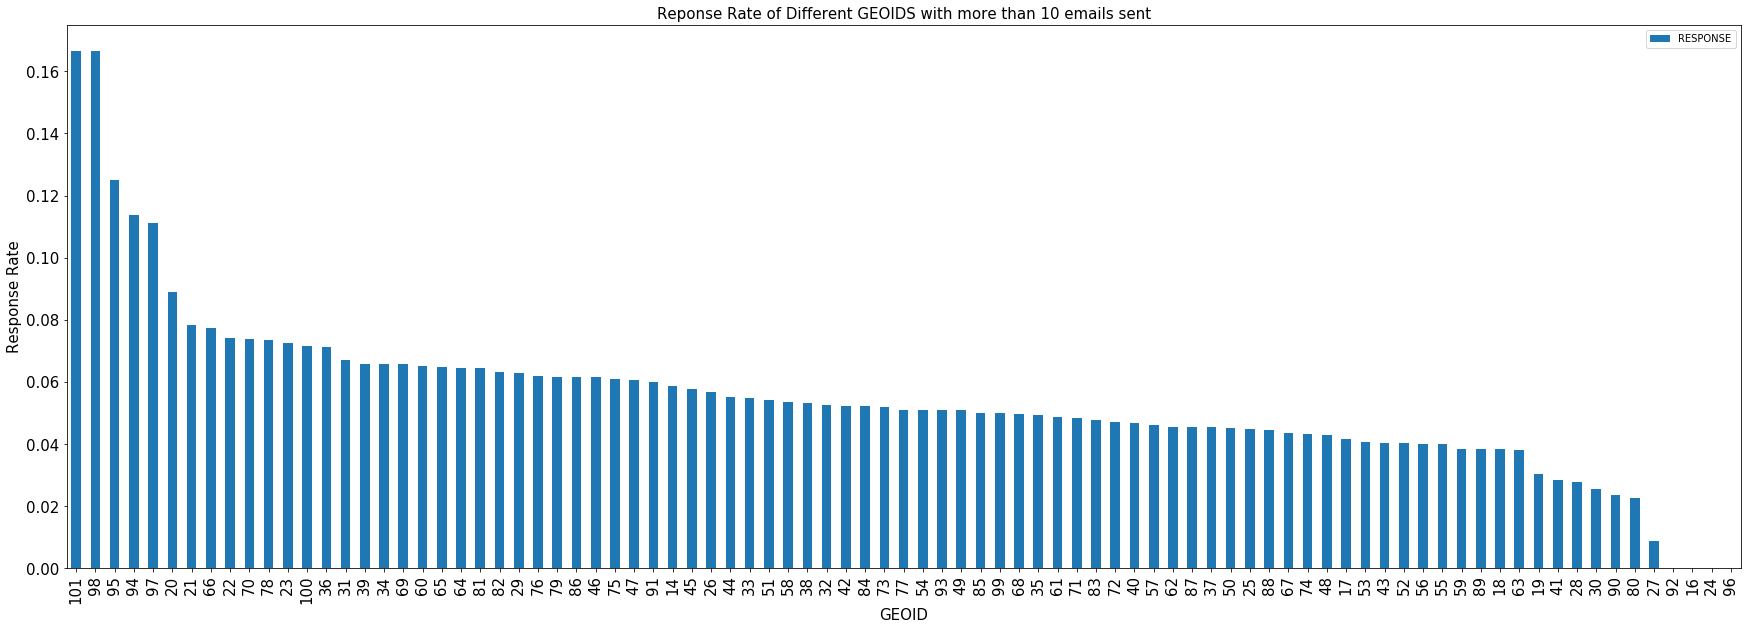

In [93]:
ax = df_merged[df_merged.GEOID.isin(valid_geoids)][['RESPONSE','GEOID']].groupby('GEOID')\
            .mean().sort_values('RESPONSE', ascending=False).plot(kind='bar', figsize=(30,10),\
            fontsize=15)
ax.set_ylabel("Response Rate",fontsize=15)
ax.set_xlabel("GEOID",fontsize=15)
ax.set_title('Reponse Rate of Different GEOIDS with more than 10 emails sent', fontsize=15)               

From the bar chart above, there is a significant response rate from certain demographics (>10%).  These seem to be strong areas to send targeted emails out.  On the other hand, demographics with low resopnse rates provides an area of opportunity.  We check these parts closer.

## Demographic Data Analysis Part 2

In [96]:
grped_resp_rate = df_merged[df_merged.GEOID.isin(valid_geoids)][['RESPONSE','GEOID']].groupby('GEOID')\
            .mean().sort_values('RESPONSE', ascending=False)
grped_resp_rate.head(10)

,RESPONSE
GEOID,
101,0.166667
98,0.166667
95,0.125000
94,0.113636
97,0.111111
20,0.088889
21,0.078431
66,0.077259
22,0.074074
